# Data cleaning and preprocessing

This project is dedicated to the application of machine learning algorithms and tools to analysis of anthropological and sociological datasets. We would experiment with both supervised and unsupervised learning algorithms, such as clustering, decision trees, association rules, and artificial neural networks and many others. The goal is to extract meaningful patterns from such datasets as World Value Survey.

Before we apply any algorithms to the WVS data, we need to make sure that the data has high quality. We need to detect and correct corrupt, invalid, or inaccurate records from the data set and changing the range of data value for easiler processing later.

# 1. Data cleaning

1. Add v1 headers to dataset and save under different name
2. Remove columns which need to be combined into one column
3. Store this in a new file
4. Replace the negative value
5. Drop NA, see the length before and after

6. if the length is sufficient, then counts per country and store it in a file
7. put the labels of clusters in country and show to Marina
8. we will select several most representative country in each cluster
9. normalize values
10. run clustering algorithm with different k from 1 to 10 and output result to file
11. hierarchical clustering
12. remove objective and do clustering again

data_0.csv: data with headers(the title of questions)  
data_1.csv: data with columns combined, religion code transformed  
data_2.csv: data with negative values replaced  
data_3.csv: data with invalid/meaningless data dropped  
data_4.csv: normalized data  
data_5.csv: normalized data with only several most representative country in each cluster  
data_6.csv: data with labels from clustering

cleaned_religion.csv: religion name with corresponding index and type 

country.csv: cleaned country name with index  

country_respondent.csv: number of respondents per country  

country_respondent_3.csv: number of respondents per country (dropna > 5000) with manually  labeled cluster of most representative countries     

result.csv: clustering result with cluster labels, country cluster label, number of respondents for each country label in each cluster

In [2]:
raw_data = "../data_set/cultural_data/clean_data/clean_data.csv"
WVS_questions = "../data_set/cultural_data/clean_data/WVS_topics_questions2.csv"
country_name = "../data_set/cultural_data/clean_data/country_code.csv"
religion_name = "../data_set/cultural_data/clean_data/religion_code.csv"

In [3]:
import pandas as pd
import numpy as np

data = pd.read_csv(raw_data,header=None)
questions = pd.read_csv(WVS_questions,header=None)
country = pd.read_csv(country_name,header=None)
religion = pd.read_csv(religion_name,header=None)

Add headers to dataframes of questions, country, religion and add the title of questions as headers to data.

In [4]:
questions.columns = ["title","min","max","type","norm_type","text"]
data.columns = questions["title"]
country.columns = ["name"]
religion.columns = ["data","name","type"]

data.to_csv("../data_set/cultural_data/clean_data/data_0.csv", index = False)

Combine the dulplicate columns with norm_type = 66,77 into separate columns

In [5]:
# Combine columns of invalid value
ls = [[],[]]
ls[0] = ['V125_'+str(i) for i in range(16)]
ls[1] = ['V215_'+str(i) for i in range(1,19)]
ls[1].remove('V215_9')
name = ['V125','V215']
text = ['confidence in organization','I see myself as which group']

for i in range(len(ls)):
    columns = ls[i]
    frames = []
    result = pd.DataFrame(index=data.index)

    for column in columns:
        cur_data = data[data[column] != -4][column]
        frames.append(cur_data)

    result = pd.concat(frames)
    result_clean = result.reset_index().drop_duplicates(subset='index',keep='first').set_index('index')

    index = data.columns.get_loc(columns[0])
    data = data.drop(columns=columns)
    n = name[i]
    data.insert(index,n,result_clean)
    data[n] = data[n].fillna(-1)
    data[n] = data[n].astype(int)

    question = questions[questions['title'] == ls[i][0]].iloc[0]
    row = [n,question['min'],question['max'],question['type'],3,text[i]]
    a_series = pd.Series(row, index = questions.columns)
    questions = questions.append(a_series, ignore_index=True)


Clean the religion dataset, output the cleaned religion and convert the religion column in data to categorical codes

In [6]:
cleaned_religion = religion[4:].reset_index()

religion_df = pd.DataFrame(columns=["index","name","type_n"])
religion_data = cleaned_religion["data"].str.split("'", n = 1, expand = True)
religion_data[1] = religion_data[1].str.replace("'","")
religion_data[0] = religion_data[0].astype(int)

religion_map = {'Non-religious':0,'Spiritualism':1,'General':2,'Judaism':3,'Christianity':4,'Islam':5,
                'Syncretism':6,'Confucianism':7,'Taoism':8,'Buddhism':9,'Ethnic':10,
                'Jainism':11,'Paganism':12,'Zoroastrianism':13,np.nan:-1}
religion_df["index"],religion_df["name"] = religion_data[0],religion_data[1]
religion_df["type_n"] = [religion_map[x] for x in cleaned_religion["type"]]

new = pd.DataFrame({"index":[-5,-4,-2,-1],"name":["Na"]*4,"type_n":[-1]*4})
religion_df = pd.concat([religion_df,new]).reset_index().drop(columns=["level_0"])
print(religion_df)
religion_df.to_csv("../data_set/cultural_data/clean_data/cleaned_religion.csv", index = False)

data["V144"] = [religion_df[religion_df["index"]==x]["type_n"].iloc[0] for x in data["V144"]]

print(data["V144"])
data.to_csv("../data_set/cultural_data/clean_data/data_1.csv", index = False)


      index                               name  type_n
0         0                               None       0
1         1                          Aglipayan       4
2         2                           Al-Hadis       5
3         3                           Alliance       4
4         4  Ancestral worshipping / Tradition      10
..      ...                                ...     ...
97   710002   ZA: African Traditional Religion      10
98       -5                                 Na      -1
99       -4                                 Na      -1
100      -2                                 Na      -1
101      -1                                 Na      -1

[102 rows x 3 columns]
0        5
1        5
2        5
3        5
4        5
        ..
90345    4
90346    4
90347    4
90348    4
90349    4
Name: V144, Length: 90350, dtype: int64


Replace the negative value with NA, drop the columns with more than 5000 NA and then drop all rows with NA

In [7]:
data[data<0] = np.nan
print(len(data))
ls = []
for column in data.columns:
    if data[column].isnull().sum() > 5000:
        ls.append(column)

drop_text = [questions[questions["title"]==x]["text"].iloc[0] for x in ls]
drop_df = pd.DataFrame(list(zip(ls,drop_text)),columns =["index", "text"]) 
drop_df.to_csv("../data_set/cultural_data/clean_data/dropped_columns.csv", index = False)

cur_data = data.drop(columns = ls)
cur_data = cur_data.dropna()
print(len(cur_data))

data = cur_data
data.to_csv("../data_set/cultural_data/clean_data/data_2.csv", index = False)


90350
37401


Or we can also impute negative values with the values from the respondent of the same country

Process country dataframe and output the cleaned country dataset and the respondent per country

In [8]:
# Processing country names
new = country['name'].str.split("'", n = 1, expand = True)
new[1] = new[1].str.replace("'","")
new[0] = new[0].astype(int)
country['index'], country['name'] = new[0],new[1]
country.to_csv("../data_set/cultural_data/clean_data/country.csv", index = False)

In [9]:
country_data = data.groupby(["V2"]).count().sort_values(["V4"],ascending=False)

country_df = pd.DataFrame(columns=["name","index","respondents"])
country_df["index"] = country_data.index
country_df["respondents"] = np.array(country_data['V4'])

country_df["name"] = [country[country['index'] == x]['name'].iloc[0] for x in country_df["index"]]

country_df.to_csv("../data_set/cultural_data/clean_data/country_respondent.csv", index = False)


Drop values in the data with invalid data or not meaningful data

In [10]:
# Remove columns containing year of birth, weight, language
data = data.drop(columns=["V241","V258","V247"])

# Remove columns containing objective values
rm_columns = questions[questions["type"]=="Objective"]["title"]
ls = list(rm_columns) + list(data.columns)
rm_columns = list(set([x for x in ls if ls.count(x) > 1]))
rm_columns.remove("V2")

data = data.drop(columns=rm_columns)
data.to_csv("../data_set/cultural_data/clean_data/data_3.csv", index = False)

Normalize the dataset

In [11]:
# Normalize the data
columns = data.columns.to_list()
columns.remove("V2")

for column in columns:
    minimum = int(data[column].min())
    maximum = int(data[column].max())
    norm_type = questions[questions["title"]==column].norm_type.iloc[0]
    
    if norm_type == 2:
        for i in range(minimum,maximum+1):
            index = data.columns.get_loc(column) + i
            name = column+"_"+str(i)
            col = [0]*len(data[column])
            for j in range(len(data[column])):
                col[j] = 1 if data[column].iloc[j] == i else 0
            data.insert(index,name,col)
        data = data.drop(columns=[column])

    elif norm_type == 1:
        data[column] = (data[column]-minimum)/(maximum-minimum)
        
    elif norm_type == 3:
        data[column] = 1-(data[column]-minimum)/(maximum-minimum)
        
data.to_csv("../data_set/cultural_data/clean_data/data_4.csv", index = False)

We put the labels of cultural clusters in country_respondent.csv and we will select several most representative country in each cultural cluster to enhance the clustering result

In [12]:
country_r_name = "../data_set/cultural_data/clean_data/country_respondent_3.csv"
country_r = pd.read_csv(country_r_name,header=0)

data["V2"] = [country_r[country_r['index'] == x]['label'].iloc[0] for x in data["V2"]]
data = data[data["V2"] > 0]
data.drop(columns=["V2"])

data.to_csv("../data_set/cultural_data/clean_data/data_5.csv", index = False)

After cleaning up data and normilizing data, we can begin to use kmeans model implemented in sklearn to cluster data.

We compute SSE for each cluster size, plot it on the graph and try to find an elbow point that indicated the best k value.

3
4
5
6
7
8
9
10
11


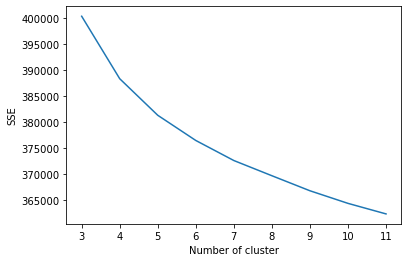

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

sse = {}
for i in range(3,12):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    sse[i] = kmeans.inertia_ 
    print(i)

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()


In [14]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(data)
labels = kmeans.labels_

data["label"] = labels
result = data.groupby(["label","V2"]).agg({'V4': ["count"]}).reset_index()
result.rename(columns={"label": "cluster", "V2": "country_label","V4":"number_of_respondents"}, inplace=True)

data.to_csv("../data_set/cultural_data/clean_data/data_6.csv", index = False)
result.to_csv("../data_set/cultural_data/clean_data/result.csv", index = False)
print(result)

   cluster country_label number_of_respondents
                                         count
0        0             1                     2
1        0             2                  1458
2        0             3                  1841
3        0             4                   100
4        1             6                   350
5        1             7                  3302
6        2             4                    44
7        2             5                   341
8        2             6                  2735
9        2             7                   100
10       3             1                  3756
11       3             2                     8
12       4             3                     2
13       4             4                  1322
14       4             5                  3433
15       4             6                   188
16       5             2                     5
17       5             3                  1322
18       5             4                     2
19       5   

In [54]:
conf_mtr = pd.DataFrame(columns=["Sub-Saharan Africa","Middle East","South Asia","Eastern Europe","East Asia","Western Europe","Latin America"])
pro_mtr = pd.DataFrame(columns=["Sub-Saharan Africa","Middle East","South Asia","Eastern Europe","East Asia","Western Europe","Latin America"])

for i in range(7):
    cdf = result[result["cluster"]==i]
    cdf["country_label"].apply(lambda x:x-1)
    
    cdf = cdf.drop(columns=["cluster"])
    cdf = cdf.set_index("country_label").reindex(range(7),fill_value=0)
    
    row = cdf["number_of_respondents"]["count"].tolist()
    prow = [x/sum(row) for x in row]
    conf_mtr.loc[len(conf_mtr)] = row
    pro_mtr.loc[len(pro_mtr)] = prow
    
print(conf_mtr)
print(pro_mtr)
    

  Sub-Saharan Africa Middle East South Asia Eastern Europe East Asia  \
0                  0           2       1458           1841       100   
1                  0           0          0              0         0   
2                  0           0          0              0        44   
3                  0        3756          8              0         0   
4                  0           0          0              2      1322   
5                  0           0          5           1322         2   
6                  0        1167         76            552         6   

  Western Europe Latin America  
0              0             0  
1              0           350  
2            341          2735  
3              0             0  
4           3433           188  
5              6             0  
6              0             0  
   Sub-Saharan Africa  Middle East  South Asia  Eastern Europe  East Asia  \
0                 0.0     0.000588    0.428697        0.541311   0.029403   
1    

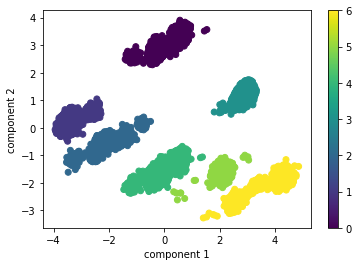

In [58]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
projected = pca.fit_transform(data)

plt.scatter(projected[:, 0], projected[:, 1], c=data.label)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();